# Pretrained model weights are not frozen it changes during training
 unless  explicitly set them to requires_grad=False
 
 #Freeze the pretrained layers
        for param in self.convnet.parameters():
            param.requires_grad = False

import os
import random
import shutil

def split_images(image_dir, train_dir, valid_dir, validation_percentage=20):
    # Create train and validation directories if they don't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(valid_dir, exist_ok=True)

    # Collect all .tiff files from all subdirectories
    image_files = []
    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.lower().endswith(('.tiff', 'tiff')):
                image_files.append(os.path.join(root, file))

    # Shuffle the files randomly
    random.shuffle(image_files)

    # Split the images into training and validation sets
    total_images = len(image_files)
    validation_count = int(total_images * validation_percentage / 100)

    validation_files = image_files[:validation_count]
    training_files = image_files[validation_count:]

    # Move files to train and validation directories
    for file_path in training_files:
        destination = os.path.join(train_dir, os.path.basename(file_path))
        shutil.copy(file_path, destination)

    for file_path in validation_files:
        destination = os.path.join(valid_dir, os.path.basename(file_path))
        shutil.copy(file_path, destination)

    print(f"Total images: {total_images}")
    print(f"Training images: {len(training_files)}")
    print(f"Validation images: {len(validation_files)}")

# Example usage
image_dir = r"../../tiff_experiment_unsupervised_data/combined"
train_dir = r"../../tiff_experiment_unsupervised_data/train"
valid_dir = r"../../tiff_experiment_unsupervised_data/validation"

split_images(image_dir, train_dir, valid_dir, validation_percentage=20)


In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms

import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import random
#from helper import set_seed

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Now you can use the `device` variable
print(f"Using device: {device}")

Using device: cuda


In [3]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay,max_epochs):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=max_epochs, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            #self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos
    

    def inference_epoch(self, inference_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(inference_loader, desc="Inferencing", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(inference_loader)
        avg_top1_acc = total_top1_acc / len(inference_loader)
        avg_top5_acc = total_top5_acc / len(inference_loader)
        avg_mean_pos = total_mean_pos / len(inference_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [4]:
# Define file paths
model_path = r'C:\Users\k54739\saved_model\ohneContrastSweetcrop_simclr_model_epoch_245.pth'

simclr_model = torch.load(model_path)
simclr_model.to(device)
simclr_model.eval()

# above error suggests u need to load state rather than full

In [5]:
# Reinitialize the model
simclr_model = SimCLR(hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4,max_epochs=245)
simclr_model.load_state_dict(torch.load(model_path))
simclr_model.to(device)
simclr_model.eval()
# Load the metrics
#loaded_metrics = torch.load(metrics_path)


C:\Users\k54739\AppData\Local\Temp\ipykernel_24428\2711482870.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_model.load_state_dict(torch.load(model_path))


SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

Inference before projection head

# Logistic

In [6]:
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.metrics import accuracy_score

In [7]:
class LabeledImageDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Convert to a torch tensor and add channel dimension
        image = torch.tensor(image, dtype=torch.float32)
        
        # Apply resize transform
        image = self.resize_transform(image)

        label = self.labels[idx]

        return image, label

def load_and_split_data(root_dir, test_size=0.2):
    
    classes = ['cond7_all', 'sd','ex']
    image_files = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        labels.extend([idx] * len(files))
    
    # Check if the labels correctly reflect the classes
    #print("Label distribution:", {classes[i]: labels.count(i) for i in range(len(classes))})
    
    # Split data into training and test sets
    train_files, test_files, train_labels, test_labels = train_test_split(
        image_files, labels, test_size=test_size, stratify=labels, random_state=42)

    return train_files, test_files, train_labels, test_labels


# Directories for labeled data
image_dir = r"G:\classification"

# Load and split the data
train_files, test_files, train_labels, test_labels = load_and_split_data(image_dir, test_size=0.2)

# Create the labeled datasets
train_labeled_dataset = LabeledImageDataset(train_files, train_labels)
test_labeled_dataset = LabeledImageDataset(test_files, test_labels)

# Define DataLoaders
batch_size = 16
train_loader_labeled = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)
test_loader_labeled = DataLoader(test_labeled_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

In [8]:
for anchor,label in train_loader_labeled:
    print(anchor.shape, label.shape, anchor.dtype)
    print(label)
    break

torch.Size([16, 3, 96, 96]) torch.Size([16]) torch.float32
tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0])


# Initialize a counter
total_images = 0

# Iterate through the DataLoader
for anchor, label in train_loader_labeled:
    total_images += anchor.size(0)  # Increment by the batch size (number of images in the current batch)

# Print the total number of images
print(f"Total number of images in train_loader_labeled: {total_images}")


# Initialize a counter
total_images = 0

# Iterate through the DataLoader
for anchor, label in test_loader_labeled:
    total_images += anchor.size(0)  # Increment by the batch size (number of images in the current batch)

# Print the total number of images
print(f"Total number of images in test_loader_labeled: {total_images}")


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        print(f"Batch features shape: {batch_feats.shape}")
        print(f"Batch labels shape: {batch_labels.shape}")
        
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    print(f"Features shape after concatenation: {feats.shape}")
    print(f"Labels shape after concatenation: {labels.shape}")

    return torch.utils.data.TensorDataset(feats, labels)

In [11]:
# Extract features for train and test datasets
train_feats_simclr = prepare_data_features(simclr_model, train_loader_labeled)
test_feats_simclr = prepare_data_features(simclr_model, test_loader_labeled)

  3%|▎         | 1/31 [00:00<00:23,  1.27it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


  6%|▋         | 2/31 [00:02<00:33,  1.16s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 10%|▉         | 3/31 [00:03<00:35,  1.28s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 13%|█▎        | 4/31 [00:05<00:36,  1.33s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 16%|█▌        | 5/31 [00:06<00:36,  1.39s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 19%|█▉        | 6/31 [00:08<00:35,  1.42s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 23%|██▎       | 7/31 [00:08<00:28,  1.18s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 26%|██▌       | 8/31 [00:10<00:33,  1.48s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 29%|██▉       | 9/31 [00:13<00:41,  1.87s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 32%|███▏      | 10/31 [00:15<00:41,  1.96s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 35%|███▌      | 11/31 [00:16<00:34,  1.72s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 39%|███▊      | 12/31 [00:17<00:29,  1.53s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 42%|████▏     | 13/31 [00:20<00:32,  1.79s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 45%|████▌     | 14/31 [00:21<00:28,  1.69s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 48%|████▊     | 15/31 [00:23<00:27,  1.71s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 52%|█████▏    | 16/31 [00:26<00:29,  1.99s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 55%|█████▍    | 17/31 [00:29<00:32,  2.32s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 58%|█████▊    | 18/31 [00:31<00:30,  2.31s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 61%|██████▏   | 19/31 [00:33<00:25,  2.16s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 65%|██████▍   | 20/31 [00:37<00:29,  2.69s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 68%|██████▊   | 21/31 [00:39<00:24,  2.44s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 71%|███████   | 22/31 [00:42<00:25,  2.84s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 74%|███████▍  | 23/31 [00:46<00:25,  3.14s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 77%|███████▋  | 24/31 [00:49<00:22,  3.15s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 81%|████████  | 25/31 [00:54<00:20,  3.43s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 84%|████████▍ | 26/31 [00:58<00:19,  3.85s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 87%|████████▋ | 27/31 [01:05<00:18,  4.64s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 90%|█████████ | 28/31 [01:11<00:15,  5.12s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 94%|█████████▎| 29/31 [01:18<00:11,  5.65s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 97%|█████████▋| 30/31 [01:25<00:06,  6.03s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


100%|██████████| 31/31 [01:29<00:00,  2.90s/it]


Batch features shape: torch.Size([12, 512])
Batch labels shape: torch.Size([12])
Features shape after concatenation: torch.Size([492, 512])
Labels shape after concatenation: torch.Size([492])


 12%|█▎        | 1/8 [00:06<00:46,  6.65s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 25%|██▌       | 2/8 [00:13<00:39,  6.64s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 38%|███▊      | 3/8 [00:20<00:34,  6.80s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 50%|█████     | 4/8 [00:26<00:26,  6.71s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 62%|██████▎   | 5/8 [00:33<00:20,  6.83s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 75%|███████▌  | 6/8 [00:40<00:13,  6.90s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 88%|████████▊ | 7/8 [00:47<00:06,  6.91s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


100%|██████████| 8/8 [00:52<00:00,  6.53s/it]

Batch features shape: torch.Size([11, 512])
Batch labels shape: torch.Size([11])
Features shape after concatenation: torch.Size([123, 512])
Labels shape after concatenation: torch.Size([123])


In [12]:
# Logistic Regression model definition
class LogisticRegression(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

In [13]:
# Training function
def train_logistic_regression(model, train_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    for batch_feats, batch_labels in tqdm(train_loader, desc="Training"):
        batch_feats, batch_labels = batch_feats.to(device), batch_labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_feats)
        loss = nn.functional.cross_entropy(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        
        # Update learning rate scheduler
        scheduler.step()

        total_loss += loss.item()

        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

In [14]:
# Evaluation function
def evaluate_logistic_regression(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_feats, batch_labels in tqdm(test_loader, desc="Evaluating"):
            batch_feats, batch_labels = batch_feats.to(device), batch_labels.to(device)
            
            outputs = model(batch_feats)
            loss = nn.functional.cross_entropy(outputs, batch_labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

In [15]:
def train_logreg_simplified(batch_size, train_feats_data, test_feats_data, feature_dim, num_classes, lr=5e-4, weight_decay=1e-4, max_epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Data loaders
    train_loader = DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                              drop_last=False, pin_memory=True, num_workers=0)
    test_loader = DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                             drop_last=False, pin_memory=True, num_workers=0)

    # Model, loss, and optimizer
    model = LogisticRegression(feature_dim, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                               milestones=[int(max_epochs * 0.6), int(max_epochs * 0.8)],
                                               gamma=0.1)

    # Store metrics
    metrics = {
        "train_losses": [],
        "test_losses": [],
        "train_accuracies": [],
        "test_accuracies": [],
    }

    # Track best by accuracy
    best_test_acc = -1.0
    best_model_state_acc = None

    # Track best by loss
    best_test_loss = float('inf')
    best_test_loss_acc = -1.0
    best_model_state_loss = None

    for epoch in range(max_epochs):
        # Training and evaluation for the current epoch
        train_loss, train_acc = train_logistic_regression(model, train_loader, optimizer, scheduler, device)
        test_loss, test_acc = evaluate_logistic_regression(model, test_loader, criterion, device)

        # Store metrics
        metrics["train_losses"].append(train_loss)
        metrics["test_losses"].append(test_loss)
        metrics["train_accuracies"].append(train_acc)
        metrics["test_accuracies"].append(test_acc)

        # Print metrics for the current epoch
        print(f"Epoch {epoch + 1}/{max_epochs}")
        print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}\n")

        # Check for best accuracy model
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_state_acc = model.state_dict()

        # Check for best loss model
        if (test_loss < best_test_loss) or (test_loss == best_test_loss and test_acc > best_test_loss_acc):
            best_test_loss = test_loss
            best_test_loss_acc = test_acc
            best_model_state_loss = model.state_dict()

    # Best models
    best_acc_model = LogisticRegression(feature_dim, num_classes).to(device)
    best_acc_model.load_state_dict(best_model_state_acc)
    best_acc_model.eval()

    best_loss_model = LogisticRegression(feature_dim, num_classes).to(device)
    best_loss_model.load_state_dict(best_model_state_loss)
    best_loss_model.eval()

    return best_acc_model, best_loss_model, metrics


In [16]:
best_acc_model, best_loss_model, metrics = train_logreg_simplified(
    batch_size=8,
    train_feats_data=train_feats_simclr,
    test_feats_data=test_feats_simclr,
    feature_dim=train_feats_simclr.tensors[0].shape[1],
    num_classes=3,
    lr=5e-4,
    weight_decay=1e-4,
    max_epochs=250
)

Evaluating: 100%|██████████| 16/16 [00:00<00:00, 506.30it/s]


Epoch 1/250
Training Loss: 0.2172, Training Accuracy: 0.9309
Test Loss: 0.0432, Test Accuracy: 0.9919



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 522.65it/s]


Epoch 2/250
Training Loss: 0.0363, Training Accuracy: 0.9980
Test Loss: 0.0219, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 520.48it/s]


Epoch 3/250
Training Loss: 0.0240, Training Accuracy: 0.9959
Test Loss: 0.0174, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 536.35it/s]


Epoch 4/250
Training Loss: 0.0213, Training Accuracy: 0.9959
Test Loss: 0.0171, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 534.93it/s]


Epoch 5/250
Training Loss: 0.0211, Training Accuracy: 0.9980
Test Loss: 0.0170, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 247.86it/s]


Epoch 6/250
Training Loss: 0.0210, Training Accuracy: 0.9980
Test Loss: 0.0169, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 259.60it/s]


Epoch 7/250
Training Loss: 0.0209, Training Accuracy: 0.9980
Test Loss: 0.0167, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 259.21it/s]


Epoch 8/250
Training Loss: 0.0208, Training Accuracy: 0.9980
Test Loss: 0.0166, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 241.34it/s]


Epoch 9/250
Training Loss: 0.0207, Training Accuracy: 0.9980
Test Loss: 0.0164, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 239.70it/s]


Epoch 10/250
Training Loss: 0.0205, Training Accuracy: 0.9980
Test Loss: 0.0163, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 245.86it/s]


Epoch 11/250
Training Loss: 0.0204, Training Accuracy: 0.9980
Test Loss: 0.0162, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 250.91it/s]


Epoch 12/250
Training Loss: 0.0205, Training Accuracy: 0.9980
Test Loss: 0.0160, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 246.12it/s]


Epoch 13/250
Training Loss: 0.0201, Training Accuracy: 0.9980
Test Loss: 0.0158, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 456.66it/s]


Epoch 14/250
Training Loss: 0.0200, Training Accuracy: 0.9980
Test Loss: 0.0157, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 505.02it/s]


Epoch 15/250
Training Loss: 0.0198, Training Accuracy: 0.9980
Test Loss: 0.0155, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 538.67it/s]


Epoch 16/250
Training Loss: 0.0196, Training Accuracy: 0.9980
Test Loss: 0.0154, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 746.21it/s]


Epoch 17/250
Training Loss: 0.0195, Training Accuracy: 0.9980
Test Loss: 0.0152, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 506.91it/s]


Epoch 18/250
Training Loss: 0.0203, Training Accuracy: 0.9980
Test Loss: 0.0150, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 466.62it/s]


Epoch 19/250
Training Loss: 0.0191, Training Accuracy: 0.9980
Test Loss: 0.0149, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 554.30it/s]


Epoch 20/250
Training Loss: 0.0191, Training Accuracy: 0.9980
Test Loss: 0.0147, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 549.80it/s]


Epoch 21/250
Training Loss: 0.0189, Training Accuracy: 0.9980
Test Loss: 0.0145, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 550.16it/s]


Epoch 22/250
Training Loss: 0.0187, Training Accuracy: 0.9980
Test Loss: 0.0144, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 511.00it/s]


Epoch 23/250
Training Loss: 0.0185, Training Accuracy: 0.9980
Test Loss: 0.0142, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 615.37it/s]


Epoch 24/250
Training Loss: 0.0184, Training Accuracy: 0.9980
Test Loss: 0.0140, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 538.56it/s]


Epoch 25/250
Training Loss: 0.0182, Training Accuracy: 0.9980
Test Loss: 0.0139, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 524.53it/s]


Epoch 26/250
Training Loss: 0.0182, Training Accuracy: 0.9980
Test Loss: 0.0137, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 586.22it/s]


Epoch 27/250
Training Loss: 0.0178, Training Accuracy: 0.9980
Test Loss: 0.0135, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 513.37it/s]


Epoch 28/250
Training Loss: 0.0178, Training Accuracy: 0.9980
Test Loss: 0.0134, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 549.38it/s]


Epoch 29/250
Training Loss: 0.0176, Training Accuracy: 0.9980
Test Loss: 0.0132, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 447.55it/s]


Epoch 30/250
Training Loss: 0.0174, Training Accuracy: 0.9980
Test Loss: 0.0130, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 592.74it/s]


Epoch 31/250
Training Loss: 0.0176, Training Accuracy: 0.9980
Test Loss: 0.0129, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 549.85it/s]


Epoch 32/250
Training Loss: 0.0170, Training Accuracy: 0.9980
Test Loss: 0.0127, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 354.16it/s]


Epoch 33/250
Training Loss: 0.0169, Training Accuracy: 0.9980
Test Loss: 0.0126, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 475.68it/s]


Epoch 34/250
Training Loss: 0.0167, Training Accuracy: 0.9980
Test Loss: 0.0124, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 563.36it/s]


Epoch 35/250
Training Loss: 0.0175, Training Accuracy: 0.9980
Test Loss: 0.0122, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 555.34it/s]


Epoch 36/250
Training Loss: 0.0165, Training Accuracy: 0.9980
Test Loss: 0.0121, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 563.88it/s]


Epoch 37/250
Training Loss: 0.0162, Training Accuracy: 0.9980
Test Loss: 0.0119, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 493.91it/s]


Epoch 38/250
Training Loss: 0.0161, Training Accuracy: 0.9980
Test Loss: 0.0118, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 531.76it/s]


Epoch 39/250
Training Loss: 0.0160, Training Accuracy: 0.9980
Test Loss: 0.0116, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 508.39it/s]


Epoch 40/250
Training Loss: 0.0161, Training Accuracy: 0.9980
Test Loss: 0.0115, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 517.81it/s]


Epoch 41/250
Training Loss: 0.0156, Training Accuracy: 0.9980
Test Loss: 0.0114, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 474.43it/s]


Epoch 42/250
Training Loss: 0.0155, Training Accuracy: 0.9980
Test Loss: 0.0112, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 560.61it/s]


Epoch 43/250
Training Loss: 0.0154, Training Accuracy: 0.9980
Test Loss: 0.0111, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 585.14it/s]


Epoch 44/250
Training Loss: 0.0152, Training Accuracy: 0.9980
Test Loss: 0.0109, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 681.92it/s]


Epoch 45/250
Training Loss: 0.0152, Training Accuracy: 0.9980
Test Loss: 0.0108, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 571.43it/s]


Epoch 46/250
Training Loss: 0.0149, Training Accuracy: 0.9980
Test Loss: 0.0107, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 563.67it/s]


Epoch 47/250
Training Loss: 0.0147, Training Accuracy: 0.9980
Test Loss: 0.0105, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 524.08it/s]


Epoch 48/250
Training Loss: 0.0146, Training Accuracy: 0.9980
Test Loss: 0.0104, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 568.70it/s]


Epoch 49/250
Training Loss: 0.0145, Training Accuracy: 0.9980
Test Loss: 0.0102, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 254.84it/s]


Epoch 50/250
Training Loss: 0.0147, Training Accuracy: 0.9980
Test Loss: 0.0101, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 211.36it/s]


Epoch 51/250
Training Loss: 0.0142, Training Accuracy: 0.9980
Test Loss: 0.0100, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 264.85it/s]


Epoch 52/250
Training Loss: 0.0141, Training Accuracy: 0.9980
Test Loss: 0.0098, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 242.17it/s]


Epoch 53/250
Training Loss: 0.0140, Training Accuracy: 0.9980
Test Loss: 0.0097, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 248.78it/s]


Epoch 54/250
Training Loss: 0.0138, Training Accuracy: 0.9980
Test Loss: 0.0096, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 236.13it/s]


Epoch 55/250
Training Loss: 0.0137, Training Accuracy: 0.9980
Test Loss: 0.0095, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 250.64it/s]


Epoch 56/250
Training Loss: 0.0136, Training Accuracy: 0.9980
Test Loss: 0.0094, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 268.60it/s]


Epoch 57/250
Training Loss: 0.0135, Training Accuracy: 0.9980
Test Loss: 0.0092, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 228.52it/s]


Epoch 58/250
Training Loss: 0.0133, Training Accuracy: 0.9980
Test Loss: 0.0091, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 559.41it/s]


Epoch 59/250
Training Loss: 0.0132, Training Accuracy: 0.9980
Test Loss: 0.0090, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 521.06it/s]


Epoch 60/250
Training Loss: 0.0131, Training Accuracy: 0.9980
Test Loss: 0.0089, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 551.74it/s]


Epoch 61/250
Training Loss: 0.0129, Training Accuracy: 0.9980
Test Loss: 0.0088, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 468.19it/s]


Epoch 62/250
Training Loss: 0.0127, Training Accuracy: 0.9980
Test Loss: 0.0087, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 545.11it/s]


Epoch 63/250
Training Loss: 0.0126, Training Accuracy: 0.9980
Test Loss: 0.0086, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 409.08it/s]


Epoch 64/250
Training Loss: 0.0125, Training Accuracy: 0.9980
Test Loss: 0.0085, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 510.48it/s]


Epoch 65/250
Training Loss: 0.0124, Training Accuracy: 0.9980
Test Loss: 0.0084, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 288.63it/s]


Epoch 66/250
Training Loss: 0.0123, Training Accuracy: 0.9980
Test Loss: 0.0083, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 2854.36it/s]


Epoch 67/250
Training Loss: 0.0122, Training Accuracy: 0.9980
Test Loss: 0.0082, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3199.77it/s]


Epoch 68/250
Training Loss: 0.0121, Training Accuracy: 0.9980
Test Loss: 0.0081, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3200.23it/s]


Epoch 69/250
Training Loss: 0.0119, Training Accuracy: 0.9980
Test Loss: 0.0080, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3818.64it/s]


Epoch 70/250
Training Loss: 0.0120, Training Accuracy: 0.9980
Test Loss: 0.0079, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3069.52it/s]


Epoch 71/250
Training Loss: 0.0117, Training Accuracy: 0.9980
Test Loss: 0.0078, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 4000.77it/s]


Epoch 72/250
Training Loss: 0.0116, Training Accuracy: 0.9980
Test Loss: 0.0077, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3115.40it/s]


Epoch 73/250
Training Loss: 0.0115, Training Accuracy: 1.0000
Test Loss: 0.0076, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3199.47it/s]


Epoch 74/250
Training Loss: 0.0114, Training Accuracy: 1.0000
Test Loss: 0.0075, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3124.39it/s]


Epoch 75/250
Training Loss: 0.0113, Training Accuracy: 1.0000
Test Loss: 0.0074, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 4001.72it/s]


Epoch 76/250
Training Loss: 0.0113, Training Accuracy: 1.0000
Test Loss: 0.0073, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3080.08it/s]


Epoch 77/250
Training Loss: 0.0115, Training Accuracy: 1.0000
Test Loss: 0.0072, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3096.57it/s]


Epoch 78/250
Training Loss: 0.0111, Training Accuracy: 1.0000
Test Loss: 0.0071, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3200.08it/s]


Epoch 79/250
Training Loss: 0.0108, Training Accuracy: 1.0000
Test Loss: 0.0070, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3199.93it/s]


Epoch 80/250
Training Loss: 0.0108, Training Accuracy: 1.0000
Test Loss: 0.0069, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3200.84it/s]


Epoch 81/250
Training Loss: 0.0107, Training Accuracy: 1.0000
Test Loss: 0.0069, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 4001.01it/s]


Epoch 82/250
Training Loss: 0.0106, Training Accuracy: 1.0000
Test Loss: 0.0068, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3199.93it/s]


Epoch 83/250
Training Loss: 0.0105, Training Accuracy: 1.0000
Test Loss: 0.0067, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3808.46it/s]


Epoch 84/250
Training Loss: 0.0105, Training Accuracy: 1.0000
Test Loss: 0.0066, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3200.23it/s]


Epoch 85/250
Training Loss: 0.0104, Training Accuracy: 1.0000
Test Loss: 0.0065, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3200.69it/s]


Epoch 86/250
Training Loss: 0.0104, Training Accuracy: 1.0000
Test Loss: 0.0065, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3200.69it/s]


Epoch 87/250
Training Loss: 0.0102, Training Accuracy: 1.0000
Test Loss: 0.0064, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3046.66it/s]


Epoch 88/250
Training Loss: 0.0101, Training Accuracy: 1.0000
Test Loss: 0.0063, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 2625.95it/s]


Epoch 89/250
Training Loss: 0.0099, Training Accuracy: 1.0000
Test Loss: 0.0062, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3200.08it/s]


Epoch 90/250
Training Loss: 0.0098, Training Accuracy: 1.0000
Test Loss: 0.0062, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3200.08it/s]


Epoch 91/250
Training Loss: 0.0098, Training Accuracy: 1.0000
Test Loss: 0.0061, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3200.08it/s]


Epoch 92/250
Training Loss: 0.0096, Training Accuracy: 1.0000
Test Loss: 0.0060, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3199.77it/s]


Epoch 93/250
Training Loss: 0.0096, Training Accuracy: 1.0000
Test Loss: 0.0060, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3199.93it/s]


Epoch 94/250
Training Loss: 0.0095, Training Accuracy: 1.0000
Test Loss: 0.0059, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3200.54it/s]


Epoch 95/250
Training Loss: 0.0094, Training Accuracy: 1.0000
Test Loss: 0.0058, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3199.16it/s]


Epoch 96/250
Training Loss: 0.0093, Training Accuracy: 1.0000
Test Loss: 0.0057, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3141.51it/s]


Epoch 97/250
Training Loss: 0.0092, Training Accuracy: 1.0000
Test Loss: 0.0057, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3148.14it/s]


Epoch 98/250
Training Loss: 0.0091, Training Accuracy: 1.0000
Test Loss: 0.0056, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 2666.65it/s]


Epoch 99/250
Training Loss: 0.0091, Training Accuracy: 1.0000
Test Loss: 0.0056, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3104.02it/s]


Epoch 100/250
Training Loss: 0.0093, Training Accuracy: 1.0000
Test Loss: 0.0055, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3119.31it/s]


Epoch 101/250
Training Loss: 0.0089, Training Accuracy: 1.0000
Test Loss: 0.0054, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3127.31it/s]


Epoch 102/250
Training Loss: 0.0089, Training Accuracy: 1.0000
Test Loss: 0.0054, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3200.23it/s]


Epoch 103/250
Training Loss: 0.0087, Training Accuracy: 1.0000
Test Loss: 0.0053, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3200.08it/s]


Epoch 104/250
Training Loss: 0.0087, Training Accuracy: 1.0000
Test Loss: 0.0053, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3200.54it/s]


Epoch 105/250
Training Loss: 0.0086, Training Accuracy: 1.0000
Test Loss: 0.0052, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3199.93it/s]


Epoch 106/250
Training Loss: 0.0086, Training Accuracy: 1.0000
Test Loss: 0.0051, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3200.08it/s]


Epoch 107/250
Training Loss: 0.0085, Training Accuracy: 1.0000
Test Loss: 0.0051, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 4000.53it/s]


Epoch 108/250
Training Loss: 0.0084, Training Accuracy: 1.0000
Test Loss: 0.0050, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3999.81it/s]


Epoch 109/250
Training Loss: 0.0084, Training Accuracy: 1.0000
Test Loss: 0.0050, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3200.69it/s]


Epoch 110/250
Training Loss: 0.0084, Training Accuracy: 1.0000
Test Loss: 0.0049, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3200.69it/s]


Epoch 111/250
Training Loss: 0.0097, Training Accuracy: 1.0000
Test Loss: 0.0048, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3200.38it/s]


Epoch 112/250
Training Loss: 0.0081, Training Accuracy: 1.0000
Test Loss: 0.0048, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3200.69it/s]


Epoch 113/250
Training Loss: 0.0080, Training Accuracy: 1.0000
Test Loss: 0.0048, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3122.94it/s]


Epoch 114/250
Training Loss: 0.0080, Training Accuracy: 1.0000
Test Loss: 0.0047, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3200.08it/s]


Epoch 115/250
Training Loss: 0.0079, Training Accuracy: 1.0000
Test Loss: 0.0047, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3200.23it/s]


Epoch 116/250
Training Loss: 0.0078, Training Accuracy: 1.0000
Test Loss: 0.0046, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3200.23it/s]


Epoch 117/250
Training Loss: 0.0078, Training Accuracy: 1.0000
Test Loss: 0.0046, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3199.93it/s]


Epoch 118/250
Training Loss: 0.0077, Training Accuracy: 1.0000
Test Loss: 0.0045, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3199.93it/s]


Epoch 119/250
Training Loss: 0.0076, Training Accuracy: 1.0000
Test Loss: 0.0045, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 4001.01it/s]


Epoch 120/250
Training Loss: 0.0076, Training Accuracy: 1.0000
Test Loss: 0.0044, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3200.23it/s]


Epoch 121/250
Training Loss: 0.0075, Training Accuracy: 1.0000
Test Loss: 0.0044, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 4000.77it/s]


Epoch 122/250
Training Loss: 0.0074, Training Accuracy: 1.0000
Test Loss: 0.0043, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3200.08it/s]


Epoch 123/250
Training Loss: 0.0074, Training Accuracy: 1.0000
Test Loss: 0.0043, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3199.16it/s]


Epoch 124/250
Training Loss: 0.0073, Training Accuracy: 1.0000
Test Loss: 0.0042, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3200.08it/s]


Epoch 125/250
Training Loss: 0.0073, Training Accuracy: 1.0000
Test Loss: 0.0042, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3999.81it/s]


Epoch 126/250
Training Loss: 0.0072, Training Accuracy: 1.0000
Test Loss: 0.0042, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3199.62it/s]


Epoch 127/250
Training Loss: 0.0073, Training Accuracy: 1.0000
Test Loss: 0.0041, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3201.00it/s]


Epoch 128/250
Training Loss: 0.0071, Training Accuracy: 1.0000
Test Loss: 0.0041, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3200.69it/s]


Epoch 129/250
Training Loss: 0.0070, Training Accuracy: 1.0000
Test Loss: 0.0040, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 4000.77it/s]


Epoch 130/250
Training Loss: 0.0070, Training Accuracy: 1.0000
Test Loss: 0.0040, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3200.84it/s]


Epoch 131/250
Training Loss: 0.0069, Training Accuracy: 1.0000
Test Loss: 0.0039, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 2666.86it/s]


Epoch 132/250
Training Loss: 0.0069, Training Accuracy: 1.0000
Test Loss: 0.0039, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 4000.53it/s]


Epoch 133/250
Training Loss: 0.0069, Training Accuracy: 1.0000
Test Loss: 0.0039, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3201.00it/s]


Epoch 134/250
Training Loss: 0.0068, Training Accuracy: 1.0000
Test Loss: 0.0038, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3201.00it/s]


Epoch 135/250
Training Loss: 0.0068, Training Accuracy: 1.0000
Test Loss: 0.0038, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 4001.01it/s]


Epoch 136/250
Training Loss: 0.0067, Training Accuracy: 1.0000
Test Loss: 0.0037, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3200.23it/s]


Epoch 137/250
Training Loss: 0.0067, Training Accuracy: 1.0000
Test Loss: 0.0037, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3199.93it/s]


Epoch 138/250
Training Loss: 0.0065, Training Accuracy: 1.0000
Test Loss: 0.0037, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3199.93it/s]


Epoch 139/250
Training Loss: 0.0065, Training Accuracy: 1.0000
Test Loss: 0.0036, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3128.04it/s]


Epoch 140/250
Training Loss: 0.0065, Training Accuracy: 1.0000
Test Loss: 0.0036, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 4000.29it/s]


Epoch 141/250
Training Loss: 0.0064, Training Accuracy: 1.0000
Test Loss: 0.0036, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3199.77it/s]


Epoch 142/250
Training Loss: 0.0064, Training Accuracy: 1.0000
Test Loss: 0.0035, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 4000.05it/s]


Epoch 143/250
Training Loss: 0.0063, Training Accuracy: 1.0000
Test Loss: 0.0035, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3999.81it/s]


Epoch 144/250
Training Loss: 0.0062, Training Accuracy: 1.0000
Test Loss: 0.0035, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 1999.85it/s]


Epoch 145/250
Training Loss: 0.0062, Training Accuracy: 1.0000
Test Loss: 0.0034, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3201.15it/s]


Epoch 146/250
Training Loss: 0.0062, Training Accuracy: 1.0000
Test Loss: 0.0034, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 2977.59it/s]


Epoch 147/250
Training Loss: 0.0061, Training Accuracy: 1.0000
Test Loss: 0.0034, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3999.81it/s]


Epoch 148/250
Training Loss: 0.0061, Training Accuracy: 1.0000
Test Loss: 0.0033, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3196.42it/s]


Epoch 149/250
Training Loss: 0.0060, Training Accuracy: 1.0000
Test Loss: 0.0033, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3196.42it/s]


Epoch 150/250
Training Loss: 0.0060, Training Accuracy: 1.0000
Test Loss: 0.0033, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 2664.21it/s]


Epoch 151/250
Training Loss: 0.0060, Training Accuracy: 1.0000
Test Loss: 0.0032, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3195.81it/s]


Epoch 152/250
Training Loss: 0.0059, Training Accuracy: 1.0000
Test Loss: 0.0032, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 2287.59it/s]


Epoch 153/250
Training Loss: 0.0059, Training Accuracy: 1.0000
Test Loss: 0.0032, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3201.76it/s]


Epoch 154/250
Training Loss: 0.0058, Training Accuracy: 1.0000
Test Loss: 0.0032, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3204.66it/s]


Epoch 155/250
Training Loss: 0.0057, Training Accuracy: 1.0000
Test Loss: 0.0031, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 2664.32it/s]


Epoch 156/250
Training Loss: 0.0057, Training Accuracy: 1.0000
Test Loss: 0.0031, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3200.23it/s]


Epoch 157/250
Training Loss: 0.0057, Training Accuracy: 1.0000
Test Loss: 0.0031, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3993.15it/s]


Epoch 158/250
Training Loss: 0.0057, Training Accuracy: 1.0000
Test Loss: 0.0030, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3200.69it/s]


Epoch 159/250
Training Loss: 0.0056, Training Accuracy: 1.0000
Test Loss: 0.0030, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3201.30it/s]


Epoch 160/250
Training Loss: 0.0056, Training Accuracy: 1.0000
Test Loss: 0.0030, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3993.62it/s]


Epoch 161/250
Training Loss: 0.0055, Training Accuracy: 1.0000
Test Loss: 0.0030, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3095.28it/s]


Epoch 162/250
Training Loss: 0.0054, Training Accuracy: 1.0000
Test Loss: 0.0029, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3992.91it/s]


Epoch 163/250
Training Loss: 0.0054, Training Accuracy: 1.0000
Test Loss: 0.0029, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3195.66it/s]


Epoch 164/250
Training Loss: 0.0054, Training Accuracy: 1.0000
Test Loss: 0.0029, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3195.51it/s]


Epoch 165/250
Training Loss: 0.0054, Training Accuracy: 1.0000
Test Loss: 0.0028, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3088.73it/s]


Epoch 166/250
Training Loss: 0.0054, Training Accuracy: 1.0000
Test Loss: 0.0028, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3195.51it/s]


Epoch 167/250
Training Loss: 0.0052, Training Accuracy: 1.0000
Test Loss: 0.0028, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3993.39it/s]


Epoch 168/250
Training Loss: 0.0053, Training Accuracy: 1.0000
Test Loss: 0.0028, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3195.36it/s]


Epoch 169/250
Training Loss: 0.0052, Training Accuracy: 1.0000
Test Loss: 0.0027, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 2285.72it/s]


Epoch 170/250
Training Loss: 0.0051, Training Accuracy: 1.0000
Test Loss: 0.0027, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3195.66it/s]


Epoch 171/250
Training Loss: 0.0051, Training Accuracy: 1.0000
Test Loss: 0.0027, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3092.29it/s]


Epoch 172/250
Training Loss: 0.0058, Training Accuracy: 1.0000
Test Loss: 0.0027, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3195.36it/s]


Epoch 173/250
Training Loss: 0.0050, Training Accuracy: 1.0000
Test Loss: 0.0026, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3202.37it/s]


Epoch 174/250
Training Loss: 0.0050, Training Accuracy: 1.0000
Test Loss: 0.0026, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3994.10it/s]


Epoch 175/250
Training Loss: 0.0049, Training Accuracy: 1.0000
Test Loss: 0.0026, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3195.51it/s]


Epoch 176/250
Training Loss: 0.0050, Training Accuracy: 1.0000
Test Loss: 0.0026, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3200.38it/s]


Epoch 177/250
Training Loss: 0.0050, Training Accuracy: 1.0000
Test Loss: 0.0026, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3199.62it/s]


Epoch 178/250
Training Loss: 0.0048, Training Accuracy: 1.0000
Test Loss: 0.0025, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3994.10it/s]


Epoch 179/250
Training Loss: 0.0048, Training Accuracy: 1.0000
Test Loss: 0.0025, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 1777.86it/s]


Epoch 180/250
Training Loss: 0.0048, Training Accuracy: 1.0000
Test Loss: 0.0025, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 1778.10it/s]


Epoch 181/250
Training Loss: 0.0047, Training Accuracy: 1.0000
Test Loss: 0.0025, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3196.12it/s]


Epoch 182/250
Training Loss: 0.0047, Training Accuracy: 1.0000
Test Loss: 0.0025, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3200.08it/s]


Epoch 183/250
Training Loss: 0.0047, Training Accuracy: 1.0000
Test Loss: 0.0024, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3196.27it/s]


Epoch 184/250
Training Loss: 0.0048, Training Accuracy: 1.0000
Test Loss: 0.0024, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3196.12it/s]


Epoch 185/250
Training Loss: 0.0046, Training Accuracy: 1.0000
Test Loss: 0.0024, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3993.62it/s]


Epoch 186/250
Training Loss: 0.0046, Training Accuracy: 1.0000
Test Loss: 0.0024, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3994.10it/s]


Epoch 187/250
Training Loss: 0.0045, Training Accuracy: 1.0000
Test Loss: 0.0023, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3195.51it/s]


Epoch 188/250
Training Loss: 0.0046, Training Accuracy: 1.0000
Test Loss: 0.0023, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3993.15it/s]


Epoch 189/250
Training Loss: 0.0045, Training Accuracy: 1.0000
Test Loss: 0.0023, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3195.81it/s]


Epoch 190/250
Training Loss: 0.0045, Training Accuracy: 1.0000
Test Loss: 0.0023, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3993.39it/s]


Epoch 191/250
Training Loss: 0.0045, Training Accuracy: 1.0000
Test Loss: 0.0023, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3994.58it/s]


Epoch 192/250
Training Loss: 0.0044, Training Accuracy: 1.0000
Test Loss: 0.0022, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 3993.15it/s]


Epoch 193/250
Training Loss: 0.0044, Training Accuracy: 1.0000
Test Loss: 0.0022, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 615.22it/s]


Epoch 194/250
Training Loss: 0.0043, Training Accuracy: 1.0000
Test Loss: 0.0022, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 648.99it/s]


Epoch 195/250
Training Loss: 0.0043, Training Accuracy: 1.0000
Test Loss: 0.0022, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 615.21it/s]


Epoch 196/250
Training Loss: 0.0049, Training Accuracy: 1.0000
Test Loss: 0.0022, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 546.28it/s]


Epoch 197/250
Training Loss: 0.0042, Training Accuracy: 1.0000
Test Loss: 0.0022, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 539.92it/s]


Epoch 198/250
Training Loss: 0.0046, Training Accuracy: 1.0000
Test Loss: 0.0021, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 568.29it/s]


Epoch 199/250
Training Loss: 0.0042, Training Accuracy: 1.0000
Test Loss: 0.0021, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 545.89it/s]


Epoch 200/250
Training Loss: 0.0041, Training Accuracy: 1.0000
Test Loss: 0.0021, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 566.00it/s]


Epoch 201/250
Training Loss: 0.0041, Training Accuracy: 1.0000
Test Loss: 0.0021, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 548.91it/s]


Epoch 202/250
Training Loss: 0.0041, Training Accuracy: 1.0000
Test Loss: 0.0021, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 560.95it/s]


Epoch 203/250
Training Loss: 0.0041, Training Accuracy: 1.0000
Test Loss: 0.0021, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 551.61it/s]


Epoch 204/250
Training Loss: 0.0041, Training Accuracy: 1.0000
Test Loss: 0.0020, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 589.85it/s]


Epoch 205/250
Training Loss: 0.0040, Training Accuracy: 1.0000
Test Loss: 0.0020, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 551.58it/s]


Epoch 206/250
Training Loss: 0.0040, Training Accuracy: 1.0000
Test Loss: 0.0020, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 580.94it/s]


Epoch 207/250
Training Loss: 0.0039, Training Accuracy: 1.0000
Test Loss: 0.0020, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 580.73it/s]


Epoch 208/250
Training Loss: 0.0039, Training Accuracy: 1.0000
Test Loss: 0.0020, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 533.30it/s]


Epoch 209/250
Training Loss: 0.0040, Training Accuracy: 1.0000
Test Loss: 0.0020, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 514.41it/s]


Epoch 210/250
Training Loss: 0.0039, Training Accuracy: 1.0000
Test Loss: 0.0020, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 571.29it/s]


Epoch 211/250
Training Loss: 0.0039, Training Accuracy: 1.0000
Test Loss: 0.0019, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 579.18it/s]


Epoch 212/250
Training Loss: 0.0038, Training Accuracy: 1.0000
Test Loss: 0.0019, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 611.12it/s]


Epoch 213/250
Training Loss: 0.0038, Training Accuracy: 1.0000
Test Loss: 0.0019, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 530.74it/s]


Epoch 214/250
Training Loss: 0.0037, Training Accuracy: 1.0000
Test Loss: 0.0019, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 592.45it/s]


Epoch 215/250
Training Loss: 0.0037, Training Accuracy: 1.0000
Test Loss: 0.0019, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 551.53it/s]


Epoch 216/250
Training Loss: 0.0037, Training Accuracy: 1.0000
Test Loss: 0.0019, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 256.35it/s]


Epoch 217/250
Training Loss: 0.0037, Training Accuracy: 1.0000
Test Loss: 0.0019, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 264.11it/s]


Epoch 218/250
Training Loss: 0.0036, Training Accuracy: 1.0000
Test Loss: 0.0018, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 265.69it/s]


Epoch 219/250
Training Loss: 0.0037, Training Accuracy: 1.0000
Test Loss: 0.0018, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 249.46it/s]


Epoch 220/250
Training Loss: 0.0036, Training Accuracy: 1.0000
Test Loss: 0.0018, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 228.58it/s]


Epoch 221/250
Training Loss: 0.0036, Training Accuracy: 1.0000
Test Loss: 0.0018, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 246.30it/s]


Epoch 222/250
Training Loss: 0.0036, Training Accuracy: 1.0000
Test Loss: 0.0018, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 252.11it/s]


Epoch 223/250
Training Loss: 0.0035, Training Accuracy: 1.0000
Test Loss: 0.0018, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 241.54it/s]


Epoch 224/250
Training Loss: 0.0035, Training Accuracy: 1.0000
Test Loss: 0.0018, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 256.57it/s]


Epoch 225/250
Training Loss: 0.0035, Training Accuracy: 1.0000
Test Loss: 0.0017, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 241.81it/s]


Epoch 226/250
Training Loss: 0.0035, Training Accuracy: 1.0000
Test Loss: 0.0017, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 247.56it/s]


Epoch 227/250
Training Loss: 0.0034, Training Accuracy: 1.0000
Test Loss: 0.0017, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 264.42it/s]


Epoch 228/250
Training Loss: 0.0035, Training Accuracy: 1.0000
Test Loss: 0.0017, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 232.52it/s]


Epoch 229/250
Training Loss: 0.0034, Training Accuracy: 1.0000
Test Loss: 0.0017, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 223.48it/s]


Epoch 230/250
Training Loss: 0.0034, Training Accuracy: 1.0000
Test Loss: 0.0017, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 216.07it/s]


Epoch 231/250
Training Loss: 0.0033, Training Accuracy: 1.0000
Test Loss: 0.0017, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 497.63it/s]


Epoch 232/250
Training Loss: 0.0033, Training Accuracy: 1.0000
Test Loss: 0.0017, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 463.18it/s]


Epoch 233/250
Training Loss: 0.0033, Training Accuracy: 1.0000
Test Loss: 0.0016, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 478.78it/s]


Epoch 234/250
Training Loss: 0.0033, Training Accuracy: 1.0000
Test Loss: 0.0016, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 432.45it/s]


Epoch 235/250
Training Loss: 0.0033, Training Accuracy: 1.0000
Test Loss: 0.0016, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 539.85it/s]


Epoch 236/250
Training Loss: 0.0033, Training Accuracy: 1.0000
Test Loss: 0.0016, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 502.11it/s]


Epoch 237/250
Training Loss: 0.0032, Training Accuracy: 1.0000
Test Loss: 0.0016, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 516.41it/s]


Epoch 238/250
Training Loss: 0.0033, Training Accuracy: 1.0000
Test Loss: 0.0016, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 229.53it/s]


Epoch 239/250
Training Loss: 0.0032, Training Accuracy: 1.0000
Test Loss: 0.0016, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 260.40it/s]


Epoch 240/250
Training Loss: 0.0032, Training Accuracy: 1.0000
Test Loss: 0.0016, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 243.28it/s]


Epoch 241/250
Training Loss: 0.0031, Training Accuracy: 1.0000
Test Loss: 0.0016, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 227.10it/s]


Epoch 242/250
Training Loss: 0.0031, Training Accuracy: 1.0000
Test Loss: 0.0015, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 246.99it/s]


Epoch 243/250
Training Loss: 0.0031, Training Accuracy: 1.0000
Test Loss: 0.0015, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 233.80it/s]


Epoch 244/250
Training Loss: 0.0031, Training Accuracy: 1.0000
Test Loss: 0.0015, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 412.75it/s]


Epoch 245/250
Training Loss: 0.0031, Training Accuracy: 1.0000
Test Loss: 0.0015, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 475.54it/s]


Epoch 246/250
Training Loss: 0.0030, Training Accuracy: 1.0000
Test Loss: 0.0015, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 517.92it/s]


Epoch 247/250
Training Loss: 0.0030, Training Accuracy: 1.0000
Test Loss: 0.0015, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 473.45it/s]


Epoch 248/250
Training Loss: 0.0030, Training Accuracy: 1.0000
Test Loss: 0.0015, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 466.69it/s]


Epoch 249/250
Training Loss: 0.0030, Training Accuracy: 1.0000
Test Loss: 0.0015, Test Accuracy: 1.0000



Evaluating: 100%|██████████| 16/16 [00:00<00:00, 501.73it/s]

Epoch 250/250
Training Loss: 0.0029, Training Accuracy: 1.0000
Test Loss: 0.0015, Test Accuracy: 1.0000



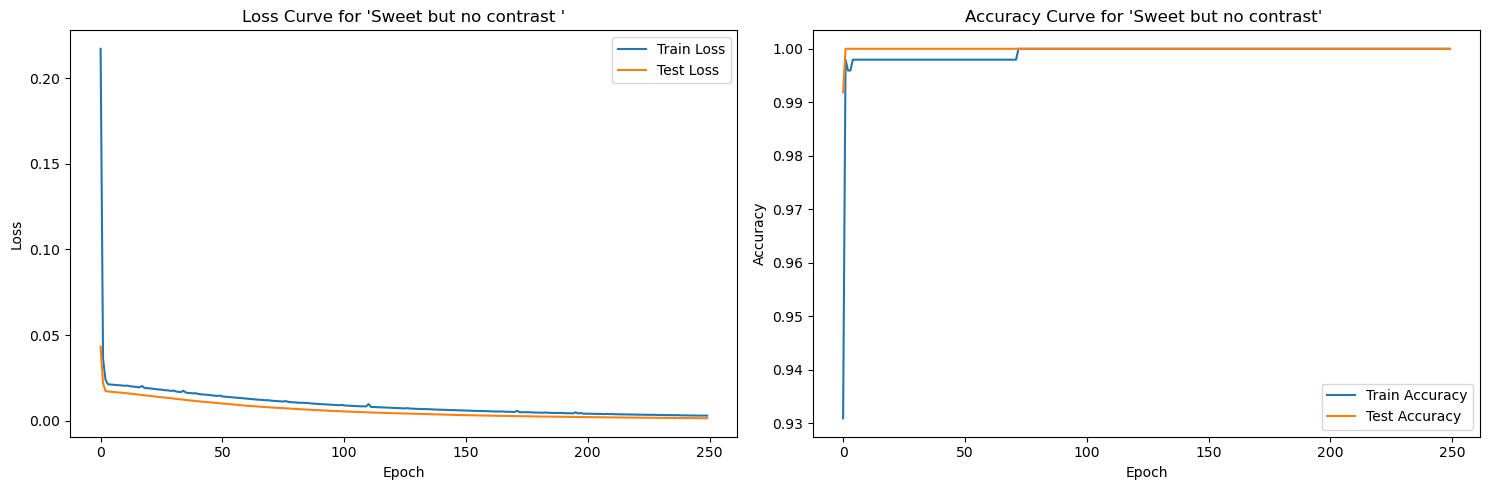

In [17]:
# Plot metrics in a separate cell
import matplotlib.pyplot as plt

# Loss curve
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics["train_losses"], label="Train Loss")
plt.plot(metrics["test_losses"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve for 'Sweet but no contrast '")
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(metrics["train_accuracies"], label="Train Accuracy")
plt.plot(metrics["test_accuracies"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve for 'Sweet but no contrast' ")
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
logreg_model= best_loss_model
logreg_model


LogisticRegression(
  (linear): Linear(in_features=512, out_features=3, bias=True)
)

In [19]:
import os
from sklearn.metrics import accuracy_score

def preprocess_new_images(folder_path, label_idx, transform=None):
    # Load the image paths and assign the same label to all
    image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(('.tiff', '.tif'))]
    labels = [label_idx] * len(image_files)
    
    # Create a dataset for the new images
    dataset = LabeledImageDataset(image_files, labels, transform=transform)
    return dataset

def inference_on_new_images(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_imgs, batch_labels in tqdm(dataloader, desc="Inference"):
            batch_imgs = batch_imgs.to(device)
            batch_labels = batch_labels.to(device)

            # Get predictions
            outputs = model(batch_imgs)
            preds = outputs.argmax(dim=1)

            # Store predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())
    
    return all_preds, all_labels

# Path to the folder containing the new images
new_images_folder = r"C:\Users\k54739\Bibi_new_thesis\thesis\classification\ds_closeto_sd"



In [20]:

# Prepare the new dataset and DataLoader
infer_dataset = preprocess_new_images(new_images_folder, label_idx=1)  # `label_idx=1` corresponds to the 'sd' class


In [21]:
infer_dataloader = DataLoader(infer_dataset, batch_size=8, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

In [22]:
for anchor,label in infer_dataloader:
    print(anchor.shape, label.shape, anchor.dtype)
    print(label)
    break

torch.Size([8, 3, 96, 96]) torch.Size([8]) torch.float32
tensor([1, 1, 1, 1, 1, 1, 1, 1])


In [23]:
infer_feats_simclr = prepare_data_features(simclr_model, infer_dataloader)

 33%|███▎      | 1/3 [00:00<00:00,  2.45it/s]

Batch features shape: torch.Size([8, 512])
Batch labels shape: torch.Size([8])


 67%|██████▋   | 2/3 [00:00<00:00,  2.29it/s]

Batch features shape: torch.Size([8, 512])
Batch labels shape: torch.Size([8])


100%|██████████| 3/3 [00:01<00:00,  2.41it/s]

Batch features shape: torch.Size([6, 512])
Batch labels shape: torch.Size([6])
Features shape after concatenation: torch.Size([22, 512])
Labels shape after concatenation: torch.Size([22])


In [24]:

# Perform inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
infer_log_loader = DataLoader(infer_feats_simclr, batch_size=8, shuffle=False,
                              drop_last=False, pin_memory=True, num_workers=0)

In [26]:

new_preds, new_labels = inference_on_new_images(best_acc_model, infer_log_loader, device)

# Calculate accuracy
accuracy = accuracy_score(new_labels, new_preds)
print(f"Inference Accuracy: {accuracy:.4f}")

# Print predictions and true labels
print("Predictions:", new_preds)
print("True Labels:", new_labels)

Inference: 100%|██████████| 3/3 [00:00<00:00, 249.98it/s]

Inference Accuracy: 0.9545
Predictions: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
True Labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [27]:

new_preds, new_labels = inference_on_new_images(best_loss_model, infer_log_loader, device)

# Calculate accuracy
accuracy = accuracy_score(new_labels, new_preds)
print(f"Inference Accuracy: {accuracy:.4f}")

# Print predictions and true labels
print("Predictions:", new_preds)
print("True Labels:", new_labels)

Inference: 100%|██████████| 3/3 [00:00<00:00, 300.01it/s]

Inference Accuracy: 0.9545
Predictions: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
True Labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


# Train the logistic regression model
# Example usage:
best_acc_model, best_loss_model, results = train_logreg_simplified(
    batch_size=8,
    train_feats_data=train_feats_simclr,
    test_feats_data=test_feats_simclr,
    feature_dim=train_feats_simclr.tensors[0].shape[1],
    num_classes=2,
    lr=5e-4,
    weight_decay=1e-4,
    max_epochs=100
)
#print(f"Final Train Accuracy: {results['train_acc']:.4f}, Final Test Accuracy: {results['test_acc']:.4f}")


# Save the best models by accuracy and loss
torch.save(best_acc_model.state_dict(), "best_acc_model.pth")
torch.save(best_loss_model.state_dict(), "best_loss_model.pth")


# 512= feature_dim = train_feats_simclr.tensors[0].shape[1] =  before projection head

# Save model state_dict
torch.save(logreg_model.state_dict(), "logreg_model_best.pth")


In [28]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for (control, sd, exploded_all) classification.
# device: torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # Dummy labels since it's just inference
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 3]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 3]
# probs[:, 0] = p(control)
# probs[:, 1] = p(sd)
# probs[:, 2] = p(exploded_all)

# Store results by group
# groups_data[group_name] = list of [p_control, p_sd, p_exploded_all, img_path]
groups_data = {g: [] for g in groups}
for p_control, p_sd, p_explod, grp, path in zip(probs[:,0], probs[:,1], probs[:,2], group_names, inference_paths):
    groups_data[grp].append([p_control, p_sd, p_explod, path])

# --------------------
# PLOTTING INDIVIDUAL DISTRIBUTIONS PER GROUP
# Now we have 3 probabilities per image. We will plot 3 histograms per group.
# --------------------

num_groups = len(groups)
# We need 3 subplots per group row now
fig, axs = plt.subplots(num_groups, 3, figsize=(15, 4*num_groups))

if num_groups == 1:
    axs = np.array([axs])  # Ensure axs is 2D even for a single group

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_sd_list = [item[1] for item in groups_data[grp]]
    p_explod_list = [item[2] for item in groups_data[grp]]

    # Plot p(control)
    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    # Plot p(sd)
    axs[i, 1].hist(p_sd_list, bins=20, alpha=0.7, edgecolor='black', color='green')
    axs[i, 1].set_title(f"{grp} Group p(sd)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

    # Plot p(exploded_all)
    axs[i, 2].hist(p_explod_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 2].set_title(f"{grp} Group p(exploded_all)")
    axs[i, 2].set_xlabel("Probability")
    axs[i, 2].set_ylabel("Count")

plt.tight_layout()
plt.show()

# --------------------
# PLOTTING COMBINED DISTRIBUTIONS ACROSS ALL GROUPS
# For each class probability, we combine distributions of all groups
# --------------------

# Combined p(control)
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# Combined p(sd)
plt.figure(figsize=(10, 5))
for grp in groups:
    p_sd_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_sd_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(sd) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# Combined p(exploded_all)
plt.figure(figsize=(10, 5))
for grp in groups:
    p_explod_list = [item[2] for item in groups_data[grp]]
    plt.hist(p_explod_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(exploded_all) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# Done!


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\softmax_dataset\\2_class\\inference'

In [21]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_sd, p_explod, img_path]
    all_images_data.extend(groups_data[grp])

In [ ]:
# Sort by p(control) in ascending order
all_images_data_pcontrol = sorted(all_images_data, key=lambda x: x[0])
sorted_by_control = [(entry[3], entry[0]) for entry in all_images_data_pcontrol]
print("Images sorted by p(control) in ascending order:")
for img_path, p_ctrl in sorted_by_control:
    print(f"{img_path}: {p_ctrl:.4f}")

print("\n" + "-"*50 + "\n")

In [ ]:
# Sort by p(sd) in ascending order
all_images_data_psd = sorted(all_images_data, key=lambda x: x[1])
sorted_by_sd = [(entry[3], entry[1]) for entry in all_images_data_psd]
print("Images sorted by p(sd) in ascending order:")
for img_path, p_sd in sorted_by_sd:
    print(f"{img_path}: {p_sd:.4f}")

In [ ]:
# Sort by p(exploded_all) in ascending order
all_images_data_pexplod = sorted(all_images_data, key=lambda x: x[2])
sorted_by_explod = [(entry[3], entry[2]) for entry in all_images_data_pexplod]
print("Images sorted by p(exploded_all) in ascending order:")
for img_path, p_explod in sorted_by_explod:
    print(f"{img_path}: {p_explod:.4f}")

In [22]:

# 750 epoch result, plot 2 is better.


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for (control, sd, exploded_all) classification.
# device: torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # Dummy labels since it's just inference
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 3]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 3]
# probs[:, 0] = p(control)
# probs[:, 1] = p(sd)
# probs[:, 2] = p(exploded_all)

# Store results by group
# groups_data[group_name] = list of [p_control, p_sd, p_exploded_all, img_path]
groups_data = {g: [] for g in groups}
for p_control, p_sd, p_explod, grp, path in zip(probs[:,0], probs[:,1], probs[:,2], group_names, inference_paths):
    groups_data[grp].append([p_control, p_sd, p_explod, path])

# --------------------
# PLOTTING INDIVIDUAL DISTRIBUTIONS PER GROUP
# Now we have 3 probabilities per image. We will plot 3 histograms per group.
# --------------------

num_groups = len(groups)
# We need 3 subplots per group row now
fig, axs = plt.subplots(num_groups, 3, figsize=(15, 4*num_groups))

if num_groups == 1:
    axs = np.array([axs])  # Ensure axs is 2D even for a single group

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_sd_list = [item[1] for item in groups_data[grp]]
    p_explod_list = [item[2] for item in groups_data[grp]]

    # Plot p(control)
    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    # Plot p(sd)
    axs[i, 1].hist(p_sd_list, bins=20, alpha=0.7, edgecolor='black', color='green')
    axs[i, 1].set_title(f"{grp} Group p(sd)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

    # Plot p(exploded_all)
    axs[i, 2].hist(p_explod_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 2].set_title(f"{grp} Group p(exploded_all)")
    axs[i, 2].set_xlabel("Probability")
    axs[i, 2].set_ylabel("Count")

plt.tight_layout()
plt.show()

# --------------------
# PLOTTING COMBINED DISTRIBUTIONS ACROSS ALL GROUPS
# For each class probability, we combine distributions of all groups
# --------------------

# Combined p(control)
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# Combined p(sd)
plt.figure(figsize=(10, 5))
for grp in groups:
    p_sd_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_sd_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(sd) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# Combined p(exploded_all)
plt.figure(figsize=(10, 5))
for grp in groups:
    p_explod_list = [item[2] for item in groups_data[grp]]
    plt.hist(p_explod_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(exploded_all) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# Done!


In [24]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_sd, p_explod, img_path]
    all_images_data.extend(groups_data[grp])

In [ ]:
# Sort by p(control) in ascending order
all_images_data_pcontrol = sorted(all_images_data, key=lambda x: x[0])
sorted_by_control = [(entry[3], entry[0]) for entry in all_images_data_pcontrol]
print("Images sorted by p(control) in ascending order:")
for img_path, p_ctrl in sorted_by_control:
    print(f"{img_path}: {p_ctrl:.4f}")

print("\n" + "-"*50 + "\n")

In [ ]:
# Sort by p(sd) in ascending order
all_images_data_psd = sorted(all_images_data, key=lambda x: x[1])
sorted_by_sd = [(entry[3], entry[1]) for entry in all_images_data_psd]
print("Images sorted by p(sd) in ascending order:")
for img_path, p_sd in sorted_by_sd:
    print(f"{img_path}: {p_sd:.4f}")

In [ ]:
# Sort by p(exploded_all) in ascending order
all_images_data_pexplod = sorted(all_images_data, key=lambda x: x[2])
sorted_by_explod = [(entry[3], entry[2]) for entry in all_images_data_pexplod]
print("Images sorted by p(exploded_all) in ascending order:")
for img_path, p_explod in sorted_by_explod:
    print(f"{img_path}: {p_explod:.4f}")